# 1: Сортировка фото кошек и собак с помощью нейронной сети

Подгружаем нужные библиотеки

In [1]:
# Импорт библиотеки TensorFlow под псевдонимом tf
import tensorflow as tf  
# Импорт модуля ImageDataGenerator для аугментации изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
# Импорт класса Model для создания модели нейронной сети
from tensorflow.keras.models import Model  
# Импорт слоев для построения нейронной сети
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
# Импорт предварительно обученной модели MobileNet и функции для предварительной 
# обработки входных данных  
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input  
# Импорт модуля для предварительной обработки изображений
from tensorflow.keras.preprocessing import image  
# Импорт модуля для математических операций
import math  
# Импорт библиотеки Matplotlib для визуализации данных
import matplotlib.pyplot as plt  
# Импорт библиотеки NumPy для работы с массивами
import numpy as np
# Импорт модуля Image из библиотеки Pillow для работы с изображениями  
from PIL import Image


**Скачиваем файлы:** https://disk.yandex.ru/d/OYYCfSzhfRcw8w \
Файлы уже отсортированы по папкам: \
– в папке ${\bf train}$ файлы для обучения нейросети \
– в папке ${\bf test}$ файлы для проверки нейросети \
Внутри этих папок есть папки ${\bf cats}$ и ${\bf dogs}$, где собрано несколько десятков фотографий с кошками и собаками. \
 \
${\bf Ответьте~на~вопрос:~для~чего~нужны~константы,~которые~вводятся~ниже?}$

In [2]:
TRAIN_DATA_DIR = '/Users/benderrr/Documents/it_8/FerrariVAZ/train'  # Путь к каталогу с обучающими данными
VALIDATION_DATA_DIR = '/Users/benderrr/Documents/it_8/FerrariVAZ/test'  # Путь к каталогу с данными для валидации
TRAIN_SAMPLES = 1000  # Общее количество обучающих примеров
VALIDATION_SAMPLES = 200  # Общее количество примеров для валидации
NUM_CLASSES = 2  # Количество классов (в данном случае два класса: 'кошки' и 'собаки')
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Размеры изображений (ширина и высота)
BATCH_SIZE = 5  # Размер пакета для обучения модели (количество образцов, обрабатываемых моделью за один шаг обучения)


Создаются два генератора данных. Для обучения нейросети недостаточно пары сотен фотографий. \
Поэтому будет использоваться такой приём как ${\bf аргументация}$ (что это?)

In [3]:
train_datagen = ImageDataGenerator(  # Создание генератора данных для обучения
    preprocessing_function=preprocess_input,  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
    rotation_range=20,  # Диапазон вращения изображений (от -20 до 20 градусов)
    width_shift_range=0.2,  # Диапазон сдвига изображений по горизонтали (относительно ширины изображения)
    height_shift_range=0.2,  # Диапазон сдвига изображений по вертикали (относительно высоты изображения)
    zoom_range=0.2  # Диапазон масштабирования изображений (от 0.8 до 1.2)
)

val_datagen = ImageDataGenerator(  # Создание генератора данных для валидации
    preprocessing_function=preprocess_input  # Предварительная обработка изображений (в данном случае с использованием функции preprocess_input)
)


In [4]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,  # Путь к каталогу с обучающими данными
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для обучения модели
    shuffle=True,  # Перемешивание данных после каждой эпохи
    seed=12345,  # Задание начального состояния для генератора случайных чисел (для воспроизводимости)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,  # Путь к каталогу с данными для валидации
    target_size=(IMG_WIDTH, IMG_HEIGHT),  # Желаемый размер изображений (ширина, высота)
    batch_size=BATCH_SIZE,  # Размер пакета для валидации модели
    shuffle=False,  # Не перемешивать данные (для сохранения порядка)
    class_mode='categorical'  # Режим классификации (в данном случае многоклассовая классификация)
)


Found 209 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


# Создание модели на основе нейронной сети, которая основана на готовой нейронной сети MobileNet (она называется базовой моделью). 
В базовой модели нужно отключить обучение (для всех слоев устанавливается **trainable = False**). \
Входное изображение поступает на вход базовой модели. \
После базовой модели добавляется несколько своих слоев: \
– слой пулинга **GlobalAveragePooling2D**; \
– полносвязный слой из **16 нейронов Dense**; \
– используется механизм Дропаут (случайное отключение нейронных связей во время обучения); \
– последний слой должен выдавать два значения (вероятности того, что на фото кошка или собака – два класса). \
Таким образом мы решаем задачу двухклассовой классификации.

In [5]:
def model_maker():
    # Создание базовой модели MobileNet без верхнего слоя классификации,
    # указывается форма входных данных (ширина, высота, количество каналов)
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Замораживаем веса всех слоев базовой модели, чтобы они не обучались
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    # Определение входного тензора модели
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Пропуск данных через базовую модель
    custom_model = base_model(input)
    
    # Глобальное пулингование для уменьшения размерности признаков
    custom_model = GlobalAveragePooling2D()(custom_model)
    
    # Полносвязный слой с 16 нейронами и функцией активации ReLU
    custom_model = Dense(32, activation='relu')(custom_model)
    
    # Слой регуляризации для предотвращения переобучения
    custom_model = Dropout(0.25)(custom_model)
    
    # Выходной слой с NUM_CLASSES нейронами и функцией активации softmax для многоклассовой классификации
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    # Создание модели с заданными входом и выходом
    return Model(inputs=input, outputs=predictions)


Компилируем и обучаем модель.

In [6]:
model = model_maker()  # Создание модели нейронной сети с помощью функции model_maker()

model.compile(loss='categorical_crossentropy',  # Функция потерь - категориальная перекрестная энтропия
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Оптимизатор - Adam с коэффициентом скорости обучения 0.001
              metrics=['acc'])  # Метрика для оценки производительности модели - точность классификации

num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # Вычисление количества шагов обучения

history = model.fit(train_generator,  # Обучение модели на обучающих данных
                steps_per_epoch=num_steps,  # Количество шагов обучения
                epochs=48,  # Количество эпох обучения
                validation_data=validation_generator,  # Данные для валидации модели
                validation_steps=num_steps)  # Количество шагов валидации

Epoch 1/48


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 13/200 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - acc: 0.6020 - loss: 0.7108

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - acc: 0.6828 - loss: 0.5868

2024-05-12 20:48:23.574558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.7600 - loss: 0.4702 - val_acc: 0.9952 - val_loss: 0.0633
Epoch 2/48


2024-05-12 20:48:25.430629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 0.9687 - loss: 0.1077

2024-05-12 20:48:27.619595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9594 - loss: 0.1091 - val_acc: 0.9952 - val_loss: 0.0348
Epoch 3/48


2024-05-12 20:48:29.176633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - acc: 0.9680 - loss: 0.0810

2024-05-12 20:48:31.256544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - acc: 0.9706 - loss: 0.0879 - val_acc: 1.0000 - val_loss: 0.0226
Epoch 4/48


2024-05-12 20:48:32.838076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9741 - loss: 0.0744

2024-05-12 20:48:34.932996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9757 - loss: 0.0720 - val_acc: 1.0000 - val_loss: 0.0243
Epoch 5/48


2024-05-12 20:48:36.505722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9868 - loss: 0.0359

2024-05-12 20:48:38.591939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9783 - loss: 0.0470 - val_acc: 1.0000 - val_loss: 0.0133
Epoch 6/48


2024-05-12 20:48:40.157510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 0.9947 - loss: 0.0392

2024-05-12 20:48:42.289322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9913 - loss: 0.0345 - val_acc: 1.0000 - val_loss: 0.0064
Epoch 7/48


2024-05-12 20:48:43.878730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - acc: 0.9994 - loss: 0.0164

2024-05-12 20:48:45.964392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9961 - loss: 0.0212 - val_acc: 1.0000 - val_loss: 0.0045
Epoch 8/48


2024-05-12 20:48:47.578410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 0.9751 - loss: 0.0484

2024-05-12 20:48:49.692558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9759 - loss: 0.0479 - val_acc: 1.0000 - val_loss: 0.0082
Epoch 9/48


2024-05-12 20:48:51.345064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0236

2024-05-12 20:48:53.440781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0238 - val_acc: 1.0000 - val_loss: 0.0098
Epoch 10/48


2024-05-12 20:48:55.026025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0112

2024-05-12 20:48:57.154494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0107 - val_acc: 1.0000 - val_loss: 0.0029
Epoch 11/48


2024-05-12 20:48:58.743791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0039

2024-05-12 20:49:00.856062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0037 - val_acc: 1.0000 - val_loss: 0.0019
Epoch 12/48


2024-05-12 20:49:02.447526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9958 - loss: 0.0154

2024-05-12 20:49:04.555393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9915 - loss: 0.0266 - val_acc: 1.0000 - val_loss: 0.0032
Epoch 13/48


2024-05-12 20:49:06.149698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - acc: 0.9965 - loss: 0.0099

2024-05-12 20:49:08.269826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9955 - loss: 0.0100 - val_acc: 1.0000 - val_loss: 8.7262e-04
Epoch 14/48


2024-05-12 20:49:09.862653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 1.0000 - loss: 0.0124

2024-05-12 20:49:11.976317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0101 - val_acc: 1.0000 - val_loss: 5.9807e-04
Epoch 15/48


2024-05-12 20:49:13.573455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 0.9910 - loss: 0.0186

2024-05-12 20:49:15.742108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9943 - loss: 0.0178 - val_acc: 1.0000 - val_loss: 4.8161e-04
Epoch 16/48


2024-05-12 20:49:17.354996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0033

2024-05-12 20:49:19.474297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0036 - val_acc: 1.0000 - val_loss: 3.9960e-04
Epoch 17/48


2024-05-12 20:49:21.099969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 1.0000 - loss: 0.0012

2024-05-12 20:49:23.230614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0012 - val_acc: 1.0000 - val_loss: 6.0719e-04
Epoch 18/48


2024-05-12 20:49:24.830547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 1.0000 - loss: 0.0064

2024-05-12 20:49:26.949624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0036 - val_acc: 1.0000 - val_loss: 6.3080e-04
Epoch 19/48


2024-05-12 20:49:28.571472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0054

2024-05-12 20:49:30.687578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0062 - val_acc: 1.0000 - val_loss: 6.1809e-04
Epoch 20/48


2024-05-12 20:49:32.309000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9968 - loss: 0.0136

2024-05-12 20:49:34.455312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9955 - loss: 0.0158 - val_acc: 1.0000 - val_loss: 0.0020
Epoch 21/48


2024-05-12 20:49:36.104528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 0.9846 - loss: 0.0361

2024-05-12 20:49:38.230950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9817 - loss: 0.0356 - val_acc: 1.0000 - val_loss: 4.0857e-04
Epoch 22/48


2024-05-12 20:49:39.865875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0043

2024-05-12 20:49:42.004211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0074 - val_acc: 1.0000 - val_loss: 3.4388e-04
Epoch 23/48


2024-05-12 20:49:43.626896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 0.9838 - loss: 0.0148

2024-05-12 20:49:45.767258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9929 - loss: 0.0073 - val_acc: 1.0000 - val_loss: 0.0027
Epoch 24/48


2024-05-12 20:49:47.396285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 0.9988 - loss: 0.0037

2024-05-12 20:49:49.536150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9960 - loss: 0.0065 - val_acc: 1.0000 - val_loss: 0.0036
Epoch 25/48


2024-05-12 20:49:51.173511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9896 - loss: 0.0147

2024-05-12 20:49:53.301278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9865 - loss: 0.0198 - val_acc: 1.0000 - val_loss: 8.1121e-04
Epoch 26/48


2024-05-12 20:49:54.920140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0082

2024-05-12 20:49:57.032646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0062 - val_acc: 1.0000 - val_loss: 0.0024
Epoch 27/48


2024-05-12 20:49:58.661607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 1.0000 - loss: 0.0015

2024-05-12 20:50:00.820420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0016 - val_acc: 1.0000 - val_loss: 0.0017
Epoch 28/48


2024-05-12 20:50:02.472623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 1.0000 - loss: 0.0033

2024-05-12 20:50:04.610795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0043 - val_acc: 1.0000 - val_loss: 1.4770e-04
Epoch 29/48


2024-05-12 20:50:06.261342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9999 - loss: 0.0035

2024-05-12 20:50:08.421301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9962 - loss: 0.0063 - val_acc: 1.0000 - val_loss: 2.3918e-04
Epoch 30/48


2024-05-12 20:50:10.073312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 0.9845 - loss: 0.0303

2024-05-12 20:50:12.223036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9854 - loss: 0.0285 - val_acc: 1.0000 - val_loss: 6.6491e-04
Epoch 31/48


2024-05-12 20:50:13.873832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 0.9956 - loss: 0.0078

2024-05-12 20:50:16.052792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9915 - loss: 0.0146 - val_acc: 1.0000 - val_loss: 1.5088e-04
Epoch 32/48


2024-05-12 20:50:17.691430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 0.9960 - loss: 0.0069

2024-05-12 20:50:19.826961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.9954 - loss: 0.0076 - val_acc: 1.0000 - val_loss: 0.0012
Epoch 33/48


2024-05-12 20:50:21.471093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0018

2024-05-12 20:50:23.667892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0017 - val_acc: 1.0000 - val_loss: 1.0470e-04
Epoch 34/48


2024-05-12 20:50:25.318400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0061

2024-05-12 20:50:27.459132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0065 - val_acc: 1.0000 - val_loss: 0.0038
Epoch 35/48


2024-05-12 20:50:29.101561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 1.0000 - loss: 6.4588e-04

2024-05-12 20:50:31.268343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0011 - val_acc: 1.0000 - val_loss: 1.5386e-04
Epoch 36/48


2024-05-12 20:50:32.926323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 1.0000 - loss: 0.0015

2024-05-12 20:50:35.072604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 0.0015 - val_acc: 1.0000 - val_loss: 3.1909e-04
Epoch 37/48


2024-05-12 20:50:36.748410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 0.0014

2024-05-12 20:50:38.887022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 8.8846e-04 - val_acc: 1.0000 - val_loss: 1.7003e-04
Epoch 38/48


2024-05-12 20:50:40.593870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 1.0000 - loss: 0.0050

2024-05-12 20:50:42.753130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0052 - val_acc: 1.0000 - val_loss: 1.4305e-04
Epoch 39/48


2024-05-12 20:50:44.431155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0018

2024-05-12 20:50:46.579905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0029 - val_acc: 1.0000 - val_loss: 8.4851e-05
Epoch 40/48


2024-05-12 20:50:48.276624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - acc: 0.9949 - loss: 0.0116

2024-05-12 20:50:50.444156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9875 - loss: 0.0258 - val_acc: 0.9952 - val_loss: 0.0114
Epoch 41/48


2024-05-12 20:50:52.140314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - acc: 0.9797 - loss: 0.0524

2024-05-12 20:50:54.292444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9844 - loss: 0.0423 - val_acc: 1.0000 - val_loss: 0.0072
Epoch 42/48


2024-05-12 20:50:56.028978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 1.0000 - loss: 0.0030

2024-05-12 20:50:58.223274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0022 - val_acc: 1.0000 - val_loss: 2.8982e-04
Epoch 43/48


2024-05-12 20:50:59.927570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0019

2024-05-12 20:51:02.088757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0034 - val_acc: 1.0000 - val_loss: 0.0015
Epoch 44/48


2024-05-12 20:51:03.821975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - acc: 0.9958 - loss: 0.0102

2024-05-12 20:51:06.029731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.9953 - loss: 0.0095 - val_acc: 1.0000 - val_loss: 0.0033
Epoch 45/48


2024-05-12 20:51:07.763883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 1.0000 - loss: 0.0014

2024-05-12 20:51:09.925386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 0.0010 - val_acc: 1.0000 - val_loss: 7.2631e-04
Epoch 46/48


2024-05-12 20:51:11.673699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 41/200 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - acc: 1.0000 - loss: 4.9263e-04

2024-05-12 20:51:13.867805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 8.1713e-04 - val_acc: 1.0000 - val_loss: 2.4522e-04
Epoch 47/48


2024-05-12 20:51:15.631697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - acc: 1.0000 - loss: 1.7958e-04

2024-05-12 20:51:17.805865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 1.0000 - loss: 2.6357e-04 - val_acc: 1.0000 - val_loss: 1.7079e-04
Epoch 48/48


2024-05-12 20:51:19.556634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 42/200 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - acc: 1.0000 - loss: 2.4988e-04

2024-05-12 20:51:21.749487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 1.0000 - loss: 2.7975e-04 - val_acc: 1.0000 - val_loss: 1.2952e-04


2024-05-12 20:51:23.477999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Построим график.

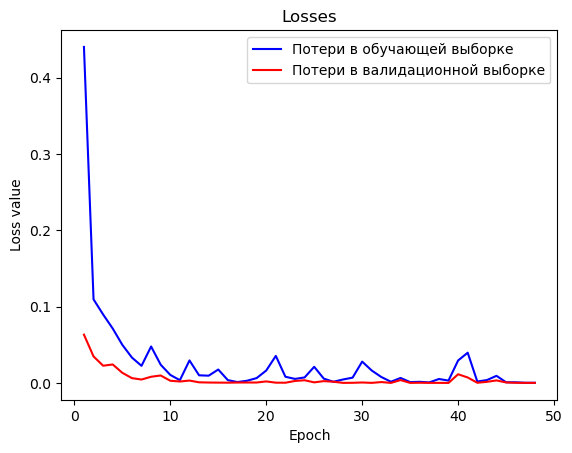

In [7]:
loss_function = history.history['loss']  # Получение значений функции потерь на обучающем наборе данных из истории обучения
val_loss_function = history.history['val_loss']  # Получение значений функции потерь на валидационном наборе данных из истории обучения
epochs = range(1, len(loss_function) + 1)  # Создание списка эпох для оси x

plt.title('Losses')  # Заголовок графика
plt.plot(epochs, loss_function, color='blue', label='Потери в обучающей выборке')  # График функции потерь на обучающем наборе
plt.plot(epochs, val_loss_function, color='red', label='Потери в валидационной выборке')  # График функции потерь на валидационном наборе
plt.xlabel('Epoch')  # Подпись оси x
plt.ylabel('Loss value')  # Подпись оси y
plt.legend()  # Добавление легенды
plt.show()  # Отображение графика




Визуализация функции потерь позволяет оценить эффективность обучения модели: мы стремимся к тому, чтобы функция потерь на обучающем и валидационном наборах данных уменьшалась с каждой эпохой, что свидетельствует о том, что модель обучается эффективно и не переобучается. \
Теперь модель можно использовать и проверить, как она работает.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


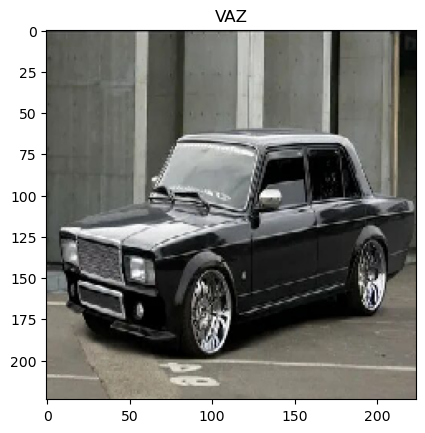

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


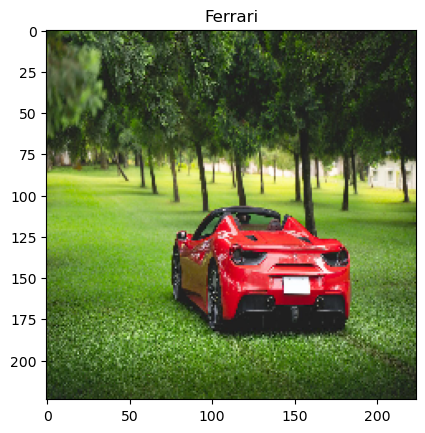

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


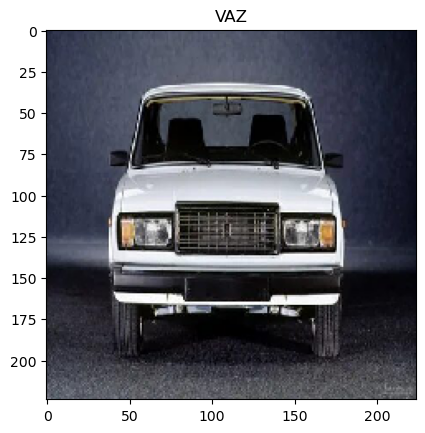

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


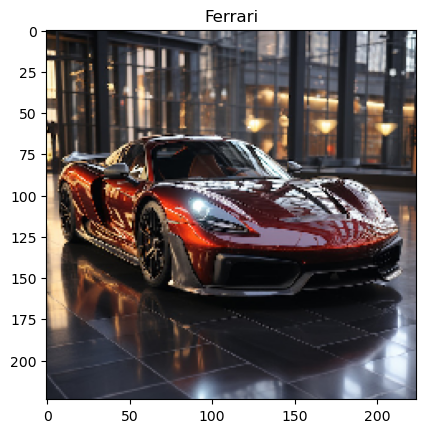

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


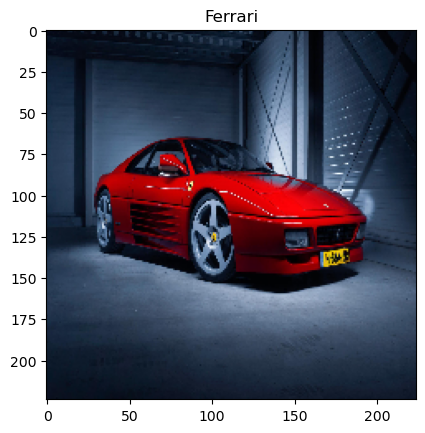

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


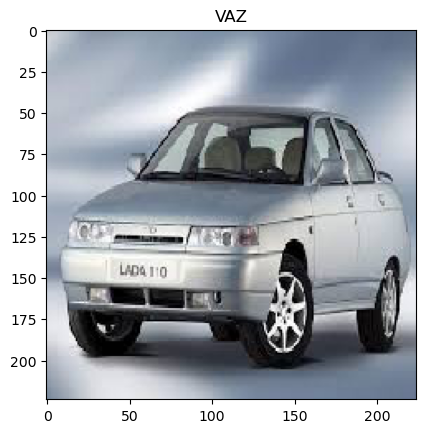

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


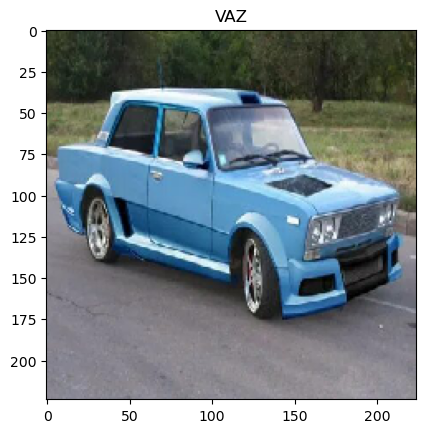

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


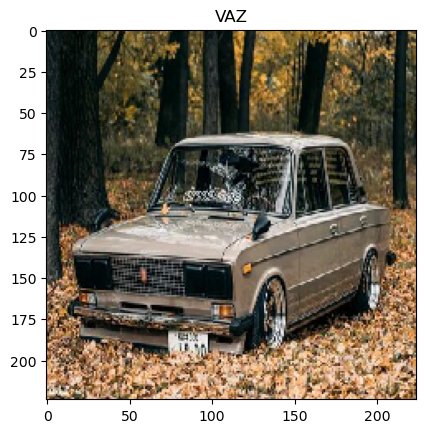

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


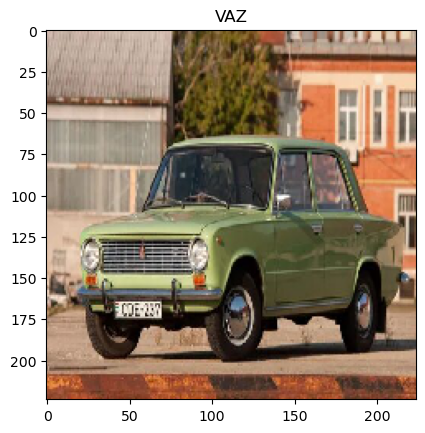

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


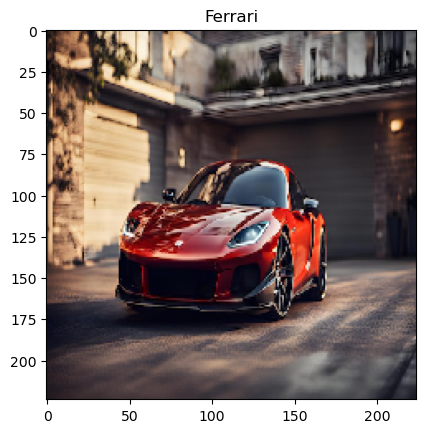

In [8]:
import os  # Импорт модуля os для работы с файловой системой
import random  # Импорт модуля random для работы с случайными числами

categ = ['Ferrari', 'VAZ']  # Список категорий: 'cat' - кошка, 'dog' - собака
files = []  # Пустой список для хранения путей к изображениям

# Перебор всех файлов в каталоге с кошками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/benderrr/Documents/it_8/FerrariVAZ/test/Ferrari'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Перебор всех файлов в каталоге с собаками и добавление путей в список files
for root, dirs, filenames in os.walk('/Users/benderrr/Documents/it_8/FerrariVAZ/test/VAZ'):
    for filename in filenames:
        files.append(os.path.join(root, filename))

# Выбор случайных 10 изображений из списка files и их отображение с предсказанием модели
for f in random.sample(files, 10):
    img_path = f  # Путь к изображению
    img = image.load_img(img_path, target_size=(224,224))  # Загрузка изображения с изменением размера до 224x224 пикселя
    img_array = image.img_to_array(img)  # Преобразование изображения в массив numpy

    expanded_img_array = np.expand_dims(img_array, axis=0)  # Расширение массива изображения
    preprocessed_img = preprocess_input(expanded_img_array)  # Предварительная обработка изображения
    prediction = model.predict(preprocessed_img)  # Получение предсказания от модели
    
    plt.title(categ[np.argmax(prediction)])  # Установка заголовка графика в соответствии с предсказанием модели
    plt.imshow(img)  # Отображение изображения
    plt.show()  # Показ графика
